In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('mps')

# Load CSV files
train_df = pd.read_csv('train_data.csv')
super_classes_df = pd.read_csv('superclass_mapping.csv')
sub_classes_df = pd.read_csv('subclass_mapping.csv')

# Function to check class imbalance
def check_class_imbalance(df, column):
    class_counts = df[column].value_counts()
    # print(f"Class distribution in {column}:\n{class_counts}")
    return class_counts

# Check for imbalance in superclass and subclass distributions
# print("Checking for class imbalance...")
superclass_imbalance = check_class_imbalance(train_df, 'superclass_index')
subclass_imbalance = check_class_imbalance(train_df, 'subclass_index')

# Map indices to class names
super_classes_map = dict(zip(super_classes_df['index'], super_classes_df['class']))
sub_classes_map = dict(zip(sub_classes_df['index'], sub_classes_df['class']))

# Get unique indices for superclasses and subclasses
unique_superclass_indices = super_classes_df['index'].unique()
unique_subclass_indices = sub_classes_df['index'].unique()

# Calculate the weights for all superclasses present in the training data
existing_superclass_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['superclass_index']),
    y=train_df['superclass_index']
)

# Calculate the weights for the subclasses present in the training data
# 'novel' class is not included since it does not appear in the training set
existing_subclass_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['subclass_index']),
    y=train_df['subclass_index']
)

novel_weight = np.mean(existing_superclass_weights)

# Now create a complete weight array including the 'novel' class
superclass_weights = np.ones(len(unique_superclass_indices))  # +1 for the novel class
superclass_weights[:len(existing_superclass_weights)] = existing_superclass_weights
superclass_weights[-1] = novel_weight  # Assigning the average weight to the 'novel' class

# Since 'novel' class index 89 does not exist in the training data, we assign it the average weight of all other classes
novel_weight = np.mean(existing_subclass_weights)

# Now create a complete weight array including the 'novel' class
subclass_weights = np.ones(len(unique_subclass_indices) + 1)  # +1 for the novel class
subclass_weights[:len(existing_subclass_weights)] = existing_subclass_weights
subclass_weights[-1] = novel_weight  # Assigning the average weight to the 'novel' class

# Convert the weight arrays to tensors
superclass_weights = torch.tensor(superclass_weights, dtype=torch.float).to(device)
subclass_weights = torch.tensor(subclass_weights, dtype=torch.float).to(device)

In [2]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_path)
        superclass_label = self.dataframe.iloc[idx, 1]
        subclass_label = self.dataframe.iloc[idx, 2]

        if self.transform:
            image = self.transform(image)

        return image, superclass_label, subclass_label

# Image transformations with advanced augmentations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Splitting the dataset
validation_split = 0.2
shuffle_dataset = True
random_seed = 42

# Creating data indices for training and validation splits
dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_dataset = CustomDataset(dataframe=train_df,
                              root_dir='train_shuffle/',
                              transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
validation_loader = DataLoader(train_dataset, batch_size=64, sampler=valid_sampler)


train_img_dir = 'train_shuffle'

# # Dataset and DataLoader
_, test_df = train_test_split(train_df, test_size=0.1, random_state=42)

# validation_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42)


# train_dataset = CustomDataset(dataframe=train_df, root_dir=train_img_dir, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# validation_dataset = CustomDataset(dataframe=validation_df, root_dir=train_img_dir, transform=transform)
# validation_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CustomDataset(dataframe=test_df, root_dir=train_img_dir, transform=transform)
test_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [3]:
# Model setup with separate heads for superclass and subclass
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the default fully connected layer

# Define new classifier for the superclasses
superclass_classifier = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),  # Adjust the input features to match the last layer of ResNet50
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, len(super_classes_df))
).to(device)

# Define new classifier for the subclasses
subclass_classifier = torch.nn.Sequential(
    torch.nn.Linear(2048, 512),  # Adjust the input features to match the last layer of ResNet50
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, len(sub_classes_df) + 1)  # +1 for the novel class
).to(device)

model = model.to(device)

# Define loss function with class weights and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=superclass_weights)
subclass_criterion = torch.nn.CrossEntropyLoss(weight=subclass_weights)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': superclass_classifier.parameters()},
    {'params': subclass_classifier.parameters()}
], lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Early stopping setup
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

# Define function to calculate accuracy
def calculate_accuracy(output, target):
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(target).sum().item()
        return correct / len(target)

train_losses_super, train_losses_sub = [], []
train_correct_super, train_correct_sub = [], []
val_losses_super, val_losses_sub = [], []
val_correct_super, val_correct_sub = [], []

# Modify the training loop to compute accuracy
for epoch in range(20):  # Adjust the number of epochs as needed
    model.train()
    superclass_classifier.train()
    subclass_classifier.train()
    
    running_loss = 0.0
    total_train_loss_super, total_train_loss_sub = 0, 0
    train_superclass_correct = 0
    train_subclass_correct = 0
    train_samples = 0
    
    for images, superclass_labels, subclass_labels in train_loader:
        inputs = images.to(device)
        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        
        optimizer.zero_grad()
        
        features = model(inputs)
        outputs_super = superclass_classifier(features)
        outputs_sub = subclass_classifier(features)
        
        loss_super = criterion(outputs_super, superclass_labels)
        loss_sub = subclass_criterion(outputs_sub, subclass_labels)
        loss = loss_super + loss_sub
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        total_train_loss_super += loss_super.item()
        total_train_loss_sub += loss_sub.item()
        train_superclass_correct += calculate_accuracy(outputs_super, superclass_labels) * images.size(0)
        train_subclass_correct += calculate_accuracy(outputs_sub, subclass_labels) * images.size(0)
        train_samples += images.size(0)
    
    avg_train_loss = running_loss / len(train_loader)
    train_super_acc = train_superclass_correct / train_samples
    train_sub_acc = train_subclass_correct / train_samples

    train_losses_super.append(total_train_loss_super / len(train_loader))
    train_losses_sub.append(total_train_loss_sub / len(train_loader))
    train_correct_super.append(train_superclass_correct / train_samples)
    train_correct_sub.append(train_subclass_correct / train_samples)
    
    # Validation phase with accuracy calculation
    model.eval()
    superclass_classifier.eval()
    subclass_classifier.eval()
    
    val_loss = 0.0
    val_superclass_correct = 0
    val_subclass_correct = 0
    val_samples = 0
    total_val_loss_super, total_val_loss_sub = 0, 0
    
    with torch.no_grad():
        for images, superclass_labels, subclass_labels in validation_loader:
            inputs = images.to(device)
            superclass_labels = superclass_labels.to(device)
            subclass_labels = subclass_labels.to(device)
            
            features = model(inputs)
            outputs_super = superclass_classifier(features)
            outputs_sub = subclass_classifier(features)
            
            loss_super = criterion(outputs_super, superclass_labels)
            loss_sub = subclass_criterion(outputs_sub, subclass_labels)
            total_val_loss_super += loss_super.item()
            total_val_loss_sub += loss_sub.item()
            val_loss += (loss_super + loss_sub).item()
            val_superclass_correct += calculate_accuracy(outputs_super, superclass_labels) * images.size(0)
            val_subclass_correct += calculate_accuracy(outputs_sub, subclass_labels) * images.size(0)
            val_samples += images.size(0)
    
    avg_val_loss = val_loss / len(validation_loader)
    val_super_acc = val_superclass_correct / val_samples
    val_sub_acc = val_subclass_correct / val_samples

    val_losses_super.append(total_val_loss_super / len(validation_loader))
    val_losses_sub.append(total_val_loss_sub / len(validation_loader))
    val_correct_super.append(val_super_acc)
    val_correct_sub.append(val_sub_acc)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Training Accuracy: Superclass - {train_super_acc:.2%}, Subclass - {train_sub_acc:.2%}")
    print(f"Validation Accuracy: Superclass - {val_super_acc:.2%}, Subclass - {val_sub_acc:.2%}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save({
            'model_state_dict': model.state_dict(),
            'superclass_classifier_state_dict': superclass_classifier.state_dict(),
            'subclass_classifier_state_dict': subclass_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'best_model_checkpoint.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model checkpoint
checkpoint = torch.load('best_model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
superclass_classifier.load_state_dict(checkpoint['superclass_classifier_state_dict'])
subclass_classifier.load_state_dict(checkpoint['subclass_classifier_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Ready to be evaluated on the test set or further tuned.

/Users/ryan_huang/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ryan_huang/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 4.3094, Val Loss: 3.8818
Training Accuracy: Superclass - 84.32%, Subclass - 7.00%
Validation Accuracy: Superclass - 84.57%, Subclass - 11.16%
Epoch 2, Train Loss: 3.4717, Val Loss: 13.8709
Training Accuracy: Superclass - 91.40%, Subclass - 13.33%
Validation Accuracy: Superclass - 84.65%, Subclass - 12.10%
Epoch 3, Train Loss: 3.1936, Val Loss: 2.9328
Training Accuracy: Superclass - 93.14%, Subclass - 19.97%
Validation Accuracy: Superclass - 91.30%, Subclass - 25.47%
Epoch 4, Train Loss: 2.8058, Val Loss: 3.1829
Training Accuracy: Superclass - 93.99%, Subclass - 25.23%
Validation Accuracy: Superclass - 86.95%, Subclass - 24.29%
Epoch 5, Train Loss: 3.0589, Val Loss: 2.6101
Training Accuracy: Superclass - 91.18%, Subclass - 26.04%
Validation Accuracy: Superclass - 91.77%, Subclass - 32.44%
Epoch 6, Train Loss: 2.4479, Val Loss: 2.4298
Training Accuracy: Superclass - 95.55%, Subclass - 32.78%
Validation Accuracy: Superclass - 93.59%, Subclass - 37.18%
Epoch 7, Train L

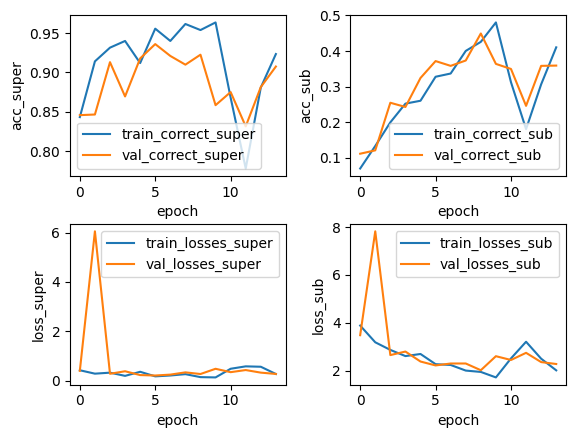

In [4]:
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.subplot(2,2,1)
plt.plot(range(len(train_correct_super)),train_correct_super,label='train_correct_super')
plt.plot(range(len(val_correct_super)),val_correct_super,label='val_correct_super')
plt.xlabel('epoch')
plt.ylabel('acc_super')
plt.legend()


plt.subplot(2,2,2)
plt.plot(range(len(train_correct_sub)),train_correct_sub,label='train_correct_sub')
plt.plot(range(len(val_correct_sub)),val_correct_sub,label='val_correct_sub')
plt.xlabel('epoch')
plt.ylabel('acc_sub')
plt.legend()

plt.subplot(2,2,3)
plt.plot(range(len(train_losses_super)),train_losses_super,label='train_losses_super')
plt.plot(range(len(val_losses_super)),val_losses_super,label='val_losses_super')
plt.xlabel('epoch')
plt.ylabel('loss_super')
plt.legend()

plt.subplot(2,2,4)
plt.plot(range(len(train_losses_sub)),train_losses_sub,label='train_losses_sub')
plt.plot(range(len(val_losses_sub)),val_losses_sub,label='val_losses_sub')
plt.xlabel('epoch')
plt.ylabel('loss_sub')
plt.legend()

plt.savefig('ressnet50.png', dpi=1000)
plt.show()

In [5]:
model.eval()
superclass_classifier.eval()
subclass_classifier.eval()
super_true, sub_true = [], []
super_pred, sub_pred = [], []
with torch.no_grad():
    for images, superclass_labels, subclass_labels in test_loader:
        inputs = images.to(device)
        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        super_true.append(superclass_labels.item())
        sub_true.append(subclass_labels.item())

        features = model(inputs)
        outputs_super = superclass_classifier(features)
        outputs_sub = subclass_classifier(features)
        _, super_predicted = torch.max(outputs_super.data, 1)
        _, sub_predicted = torch.max(outputs_sub.data, 1)

        super_pred.append(super_predicted.item())
        sub_pred.append(sub_predicted.item())

print('Superclass_f1_score:', f1_score(super_true,super_pred,average='micro'))
print('Subclass_f1_score:', f1_score(sub_true,sub_pred,average='micro'))

Superclass_f1_score: 0.9739006643467257
Subclass_f1_score: 0.5775071180006327
